# 프로젝트 8 : 인물 모드 문제점 찾기

## 목차
[Step1. 인물모드 직접 해 보기](#Step1.-인물모드-직접-해-보기)  
[Step2. 사진 모으기](#Step2.-사진-모으기)  
[Step3. 해결 방법을 제안해 보기](#Step3.-해결-방법을-제안해-보기)  
[Rubric](#Rubric)  
[회고](#회고)

## Step 1. 인물모드 직접 해 보기

### 사진 준비하기

In [1]:
import cv2
import numpy as np
import os
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

In [2]:
import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/image01.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
cat_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/image03.jpg'
img_orig = cv2.imread(img_path)
cat_orig = cv2.imread(cat_path)

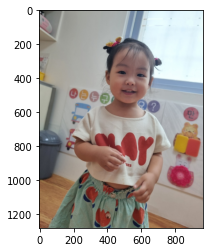

In [3]:
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

### DeepLab 모델 준비하기

#### `DeepLabModel` 클래스 만들기

In [4]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

#### 사전에 학습된 가중치(pretrained weight)를 불러오기

In [5]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


구글이 제공하는 `deeplabv3_mnv2_pascal_train_aug_2018_01_29 weight`을 다운로드하고 `DeepLabModel`을 초기화합니다. 이 모델은 PASCAL VOC 2012라는 대형 데이터셋으로 학습된 v3 버전입니다

#### 첫 단계에서 준비한 이미지를 네트워크에 입력하기

In [6]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(1280, 960, 3) (513, 384, 3) 15


#### 구글이 제공하는 DeepLab을 이용해 PASCAL VOC의 라벨로 학습하기

In [7]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

#### 마스크 만들고 시각화하기

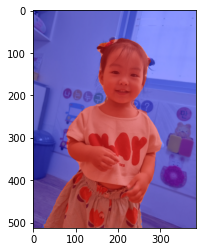

In [8]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.80, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

In [9]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(1280, 960, 3) (513, 384, 3) 15


세그멘테이션(Segmentation) 결과

### 세그멘테이션 이미지 처리하기
#### 세그멘테이션 결과(mask)를 원래 크기로 복원하기

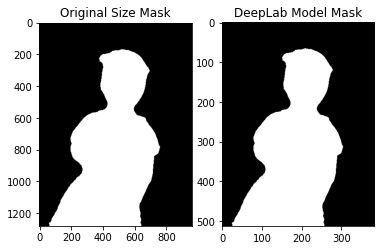

In [10]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

#### `blur()`함수 이용해 배경 흐리게 하기

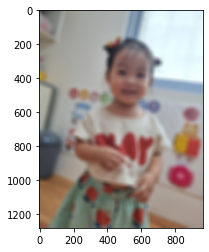

In [11]:
img_orig_blur = cv2.blur(img_orig, (30,30)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

#### 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출

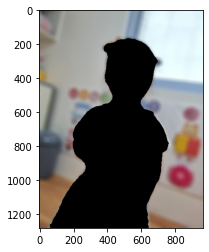

In [12]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

#### 배경 이미지와 사람 이미지 합치기

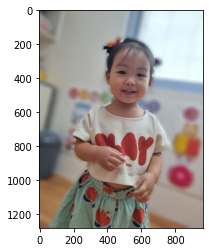

In [13]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

귀여운 아기 사진이 완성되었다.

### 귀여운 고양이 아웃포커싱 사진 만들어보기
고양이가 초점이 살짝 벗어나 있긴 하지만, 귀엽기도 하고 뭔가 고양이로 제대로 인식이 될지 궁금해 이 사진으로 시도해 보았다.

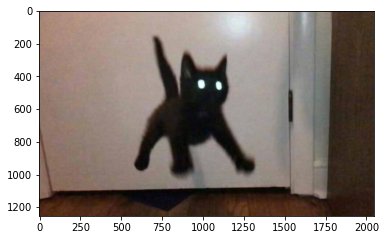

In [14]:
plt.imshow(cv2.cvtColor(cat_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [15]:
cat_resized, cat_map = MODEL.run(cat_orig)
print (cat_orig.shape, cat_resized.shape, cat_map.max())

(1253, 2048, 3) (313, 513, 3) 8


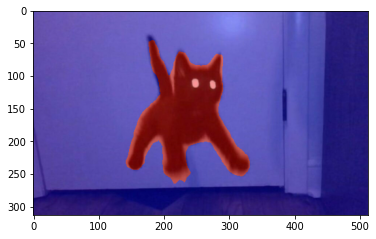

In [16]:
cat_show = cat_resized.copy()
cat_map = np.where(cat_map == 8, 8, 0) # 예측 중 고양이만 추출
cat_mask = cat_map * (255/cat_map.max()) # 255 normalization
cat_mask = cat_mask.astype(np.uint8)
cat_color_mask = cv2.applyColorMap(cat_mask, cv2.COLORMAP_JET)
cat_show = cv2.addWeighted(cat_show, 0.6, cat_color_mask, 0.80, 0.0)

plt.imshow(cv2.cvtColor(cat_show, cv2.COLOR_BGR2RGB))
plt.show()

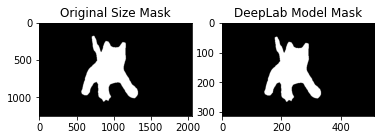

In [17]:
cat_mask_up = cv2.resize(cat_mask, cat_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, cat_mask_up = cv2.threshold(cat_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(cat_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(cat_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

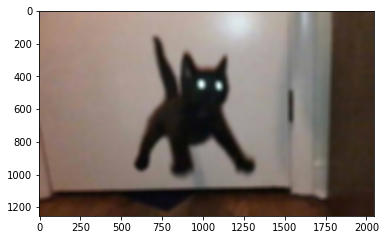

In [18]:
cat_orig_blur = cv2.blur(cat_orig, (30,30)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(cat_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

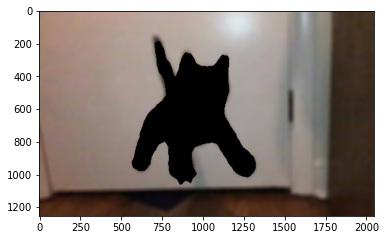

In [19]:
cat_mask_color = cv2.cvtColor(cat_mask_up, cv2.COLOR_GRAY2BGR)
cat_bg_mask = cv2.bitwise_not(cat_mask_color)
cat_bg_blur = cv2.bitwise_and(cat_orig_blur, cat_bg_mask)
plt.imshow(cv2.cvtColor(cat_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

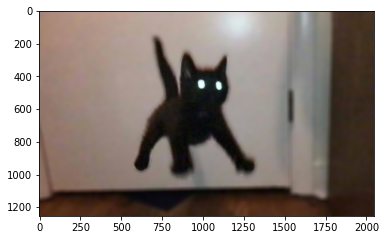

In [20]:
cat_concat = np.where(cat_mask_color==255, cat_orig, cat_bg_blur)
plt.imshow(cv2.cvtColor(cat_concat, cv2.COLOR_BGR2RGB))
plt.show()

귀여운 고양이 사진이 완성되었는데, 고양이 초점이 흐려 아웃포커싱 고양이 사진이 아닌 그냥 흐린 사진이 된 것 같다. 하지만 고양이를 잘 분류하는 것은 확인할 수 있었다.

## Step 2. 사진에서 문제점 찾기

Text(0.5, 1.0, 'Cat Blur Mask')

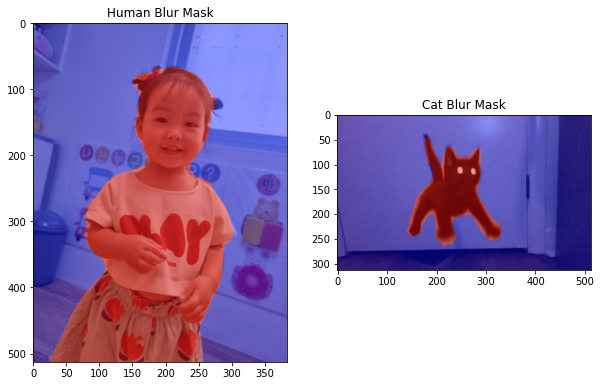

In [21]:
fig = plt.figure(figsize=(10, 10))

ax = plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
ax.set_title('Human Blur Mask')

ax = plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(cat_show, cv2.COLOR_BGR2RGB))
ax.set_title('Cat Blur Mask')

하마터면 아기의 사진에서는 마스크 영역이 매끄럽지 못한 것이 티가 덜 날 뻔했지만, 고양이의 사진은 거의 흑백으로 이루어져서 그런지 매끄럽지 못한 영역이 비교적 뚜렷하게 드러난다.  
고양이 사진에서는 꼬리가 좀 잘린 데다, 고양이 자체가 초점이 뚜렷하지 않아서 마스크 영역이 전반적으로 경계로부터 비교적 넓게 잡힌 것으로 확인된다.

## Step 3. 해결 방법을 제안해 보기

### 1. 사진을 미리 처리해보기
고양이 사진이 거의 흑백으로 이루어져 있다고 했는데, 그 점에 착안해서 사진을 흑백으로 바꾸고 밝기를 낮춰 흑백 대비를 크게 해주고 마스크를 시도해 보았다.

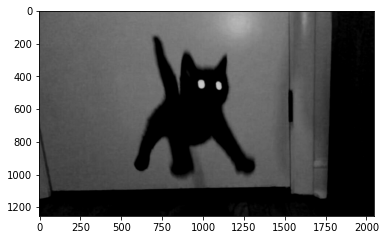

In [22]:
cat_gray = cv2.cvtColor(cat_orig, cv2.COLOR_BGR2GRAY)
cat_sub_dst = cv2.subtract(cat_gray,50)

plt.imshow(cv2.cvtColor(cat_sub_dst, cv2.COLOR_BGR2RGB))
plt.show()

In [23]:
cat_resized2, cat_map2 = MODEL.run(cat_sub_dst)

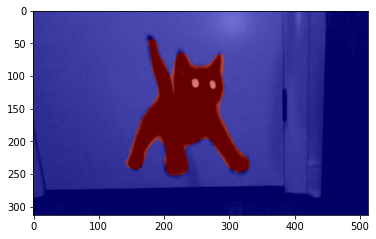

In [24]:
cat_show2 = cat_resized2.copy()
cat_gray_map = np.where(cat_map2 == 8, 8, 0) # 예측 중 고양이만 추출
cat_mask = cat_map2 * (255/cat_map2.max()) # 255 normalization
cat_mask = cat_mask.astype(np.uint8)
cat_color_mask = cv2.applyColorMap(cat_mask, cv2.COLORMAP_JET)
cat_show2 = cv2.addWeighted(cat_show2, 0.6, cat_color_mask, 0.80, 0.0)

plt.imshow(cv2.cvtColor(cat_show2, cv2.COLOR_BGR2RGB))
plt.show()

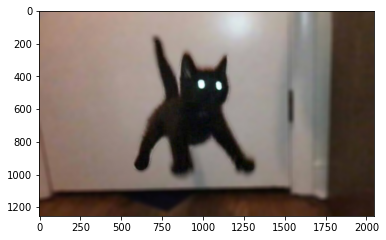

In [25]:
cat_mask_up = cv2.resize(cat_mask, cat_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, cat_mask_up = cv2.threshold(cat_mask_up, 128, 255, cv2.THRESH_BINARY)

cat_orig_blur = cv2.blur(cat_orig, (30,30)) #(13,13)은 blurring  kernel size를 뜻합니다. 

cat_mask_color = cv2.cvtColor(cat_mask_up, cv2.COLOR_GRAY2BGR)
cat_bg_mask = cv2.bitwise_not(cat_mask_color)
cat_bg_blur = cv2.bitwise_and(cat_orig_blur, cat_bg_mask)

cat_concat = np.where(cat_mask_color==255, cat_orig, cat_bg_blur)
plt.imshow(cv2.cvtColor(cat_concat, cv2.COLOR_BGR2RGB))
plt.show()

Text(0.5, 1.0, 'Cat Gray Mask')

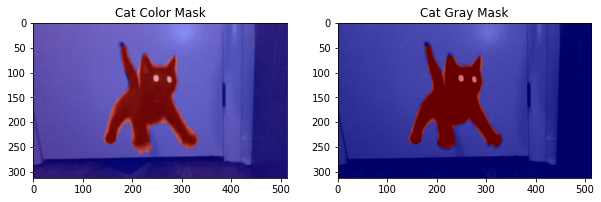

In [26]:
fig = plt.figure(figsize=(10, 10))

ax = plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(cat_show, cv2.COLOR_BGR2RGB))
ax.set_title('Cat Color Mask')

ax = plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(cat_show2, cv2.COLOR_BGR2RGB))
ax.set_title('Cat Gray Mask')

마스크 영역이 훨씬 자연스럽게 경계면과 가까워진 것으로 보아 성공적으로 개선이 된 것을 확인할 수 있다.

### 2. 필터를 Blur에서 GaussianBlur로 바꿔본다.
가우시안 블러의 커널은 중앙값이 가장 크고 중앙에서 멀어질수록 그 값이 작이진다고 한다.
따라서 대상 픽셀에 가까울수록 많은 영향을 주고, 멀어질수록 적은 영향을 준다고 하니 더 경계면의 처리에 있어서 좋은 효과를 가질 것으로 기대가 된다.

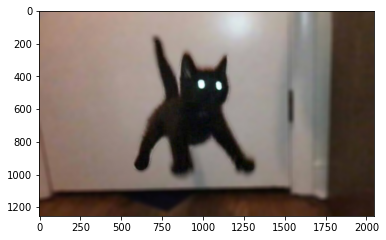

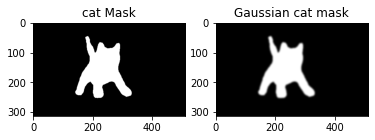

In [27]:
# 세그멘테이션 결과(mask)를 원래 크기로 복원
cat_GBmask_up = cv2.resize(cat_mask, cat_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, cat_mask_up = cv2.threshold(cat_mask_up, 128, 255, cv2.THRESH_BINARY)

# GaussianBlur 사용
cat_GBlur = cat_resized2.copy()
cat_GBlur = np.clip((cat_resized2 / 255 + np.random.normal(scale=0.1, size = cat_resized2.shape)) * 255, 0, 255).astype('uint8')

cat_GB_mask = cv2.GaussianBlur(cat_mask, (15, 15), 0)

cat_concat = np.where(cat_mask_color==255, cat_orig, cat_bg_blur)
plt.imshow(cv2.cvtColor(cat_concat, cv2.COLOR_BGR2RGB))
plt.show()

ax = plt.subplot(1,2,1)
plt.imshow(cat_mask, cmap=plt.cm.binary_r)
ax.set_title('cat Mask')

ax = plt.subplot(1,2,2)
plt.imshow(cat_GB_mask, cmap=plt.cm.binary_r)
ax.set_title('Gaussian cat mask')

plt.show()

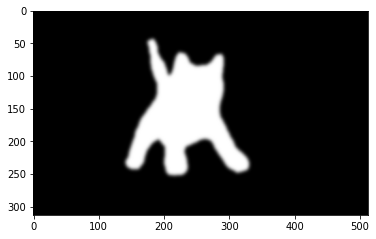

In [28]:
plt.imshow(cv2.cvtColor(cat_GB_mask, cv2.COLOR_BGR2RGB))
ax.set_title('GaussianBlur Mask')

plt.show()

In [29]:
cat_show3 = cat_resized2.copy()
cat_map = np.where(cat_map == 8, 8, 0) # 예측 중 고양이만 추출
cat_GBlur = np.clip((cat_resized2 / 255 + np.random.normal(scale=0.1, size = cat_resized2.shape)) * 255, 0, 255).astype('uint8')
# gaussian = cv2.GaussianBlur(cat_GBlur, (5, 5), 15)
cat_GB_mask = cv2.GaussianBlur(cat_mask, (15, 15), 0)
cat_color_mask_2 = cv2.applyColorMap(cat_GB_mask, cv2.COLORMAP_JET)
cat_show3 = cv2.addWeighted(cat_show3, 0.6, cat_color_mask_2, 0.80, 0.0)

In [30]:
cat_GBmask_up_2 = cv2.resize(cat_GB_mask, cat_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, cat_GBmask_up_2 = cv2.threshold(cat_GBmask_up_2, 128, 255, cv2.THRESH_BINARY)

cat_GBlur_mask = np.repeat(np.expand_dims(cat_GBmask_up_2, axis=2), 3, axis=2).astype(np.uint8)

cat_GBlur = cv2.GaussianBlur(cat_orig, (15, 15), 1)
cat_GBlur_mask = (cv2.GaussianBlur(cat_GBlur_mask, (101, 101), 25, 25)/255).astype(np.float32)

image_blur = cat_GBlur_mask*cat_orig.astype(np.float32)

img_bg_mask = (1-cat_GBlur_mask)*cat_GBlur.astype(np.float32)
img_output = (image_blur+img_bg_mask).astype(np.uint8)

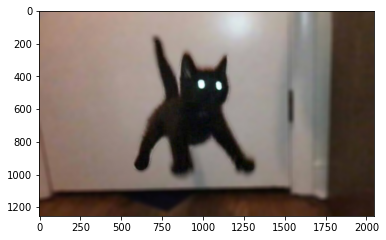

In [31]:
cat_concat = np.where(cat_mask_color==255, cat_orig, cat_bg_blur)
plt.imshow(cv2.cvtColor(cat_concat, cv2.COLOR_BGR2RGB))
plt.show()

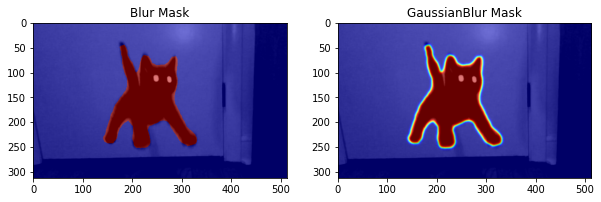

In [32]:
fig = plt.figure(figsize=(10, 10))

ax = plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(cat_show2, cv2.COLOR_BGR2RGB))
ax.set_title('Blur Mask')

ax = plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(cat_show3, cv2.COLOR_BGR2RGB))
ax.set_title('GaussianBlur Mask')

plt.show()

### 크로마키 사진 합성하기

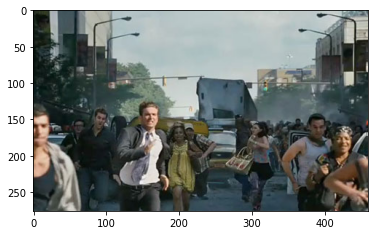

In [36]:
chr_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/image04.jpg'
chr_orig = cv2.imread(chroma_key_path)

plt.imshow(cv2.cvtColor(chr_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [43]:
cat_resized = cv2.resize(cat_orig, (chr_orig.shape[1], cat_orig.shape[0]))
chr_orig_resized = cv2.resize(chr_orig, (chr_orig.shape[1], cat_orig.shape[0]))

cat_mask_resized = cv2.resize(cat_color_mask_2, (chr_orig.shape[1], cat_orig.shape[0]))

chr_cat_concat = np.where(cat_mask_resized ==255, cat_resized, chr_orig_resized)

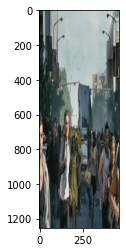

In [46]:
plt.imshow(cv2.cvtColor(chr_cat_concat, cv2.COLOR_BGR2RGB))
plt.show()

||  <center>**평가 문항**</center> |  <center>**상세 기준**</center> |
|:--------|:--------|:--------|
|**1**|인물모드 사진을 성공적으로 제작하였다.|아웃포커싱 효과가 적용된 본인의 인물모드 사진과 고양이 사진, 배경전환 크로마키사진을 각각 1장 이상 성공적으로 제작하였다.|
|**2**|제작한 인물모드 사진들에서 나타나는 문제점을 정확히 지적하였다.|인물사진에서 발생한 문제점을 정확히 지적한 사진을 제출하였다.|
|**3**|인물모드 사진의 문제점을 개선할 수 있는 솔루션을 적절히 제시하였다.|추가적인 depth 정보를 활용하여 semantic segmentation mask의 오류를 보완할 수 있는 좋은 솔루션을 구체적으로 제시하였다.|

#### 1 인물모드 사진을 성공적으로 제작하였다.
#### 2 제작한 인물모드 사진들에서 나타나는 문제점을 정확히 지적하였다.
#### 3 인물모드 사진의 문제점을 개선할 수 있는 솔루션을 적절히 제시하였다.

## 회고